In [1]:
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
import xarray
import numpy as np
from pyeosim.datasets import DATA_PATHS
from pyeosim.sensor import TdiCMOS
from pyeosim.atmosphere import Test6S
from pyeosim.plot import rgb
from pyeosim.measure import NDVI
from sklearn import linear_model

def _clean_regression_inputs(ar1, ar2):
    ar1 = ar1.stack(pix=['x','y'])
    ar2 = ar2.stack(pix=['x','y'])
    ar1 = ar1.where(~ar2.isnull())
    ar2 = ar2.where(~ar1.isnull())
    X = np.atleast_2d(ar1.dropna(dim='pix').values)
    y = ar2.dropna(dim='pix').values
    return X.T, y

def RMSE(x0, x1):
    return np.sqrt(np.sum((x0.ravel() - x1.ravel())**2)/len(x0))

def calibrate_and_score(simulation, reference,
                        index=NDVI,
                        calibration=linear_model.RANSACRegressor,
                        scorer=RMSE):
    out = {}
    # spatial interpolate simulation (NN) like input
    sim = simulation.interp(x=reference.x, y=reference.y, method='nearest')
    s, r = _clean_regression_inputs(index(sim), index(reference))
    m = calibration()
    m.fit(s, r)
    s_adj = m.predict(s)
    out['simulation'] = s.ravel()
    out['calibrated_simulation'] = s_adj
    out['reference'] = r
    out['score'] = RMSE(s, r)
    out['calibrated_score'] = RMSE(s_adj, r)
    out['calibration'] = m
    return out

def plot_linear_calibration(calibration_dict, ax):
    # generate calibration lines
    _min = calibration_dict['reference'].min()
    _max = calibration_dict['reference'].max()
    _m = calibration_dict['calibration'].estimator_.coef_
    _c = calibration_dict['calibration'].estimator_.intercept_
    x = np.linspace(_min, _max, 100)
    y_0 = x
    y_1 = (x - _c) / _m
    ax.scatter(calibration_dict['reference'],
               calibration_dict['simulation'],
               s=.1, c='r', alpha=.1)
    ax.scatter(calibration_dict['reference'],
               calibration_dict['calibrated_simulation'],
               s=.1, c='k', alpha=.1)
    ax.plot(x, y_0, 'k--')
    ax.plot(x, y_1, 'r--')
    ax.set_xlabel('Reference NDVI')
    ax.set_ylabel('Simulated NDVI')
    ax.set_title('RMSE: {:.2f}, cRMSE: {:.2f}'.format(
    calibration_dict['score'], calibration_dict['calibrated_score']))
    
def dark_noise_experiment(dark_noise, TOA, TOA_ref, reference, sensor, repeats=1):
    out = []
    for r in range(repeats):
        for dark in dark_noise:
            sensor.dark_noise = dark
            reflectance = sensor.fit_transform(TOA)/sensor.fit_transform(TOA_ref).mean(['x', 'y'])
            _re = calibrate_and_score(reflectance, reference)
            _re['dark_noise'] = dark
            _re['rep'] = r
            out.append(_re)
    return out

In [2]:
# load and preprocess imagery
fpath = DATA_PATHS['TEST_HSI_LARGE']
im = xarray.open_dataset(fpath).Reflectance
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,898)).astype(float)/10000
im_ref = im_ref[:,:200,:200]

In [3]:
atmos = Test6S()
# generate Top of Atmosphere images
TOA = atmos.transform(im_ref).compute()
TOA_ref = atmos.transform(xarray.ones_like(im_ref))
TOA_10 = atmos.transform(xarray.ones_like(im_ref)*.1)

In [42]:
cmos = TdiCMOS(integration_time=.001,
               sense_node_gain=5,
               dark_current=5,
               ccd_vref=3.1,
               adc_gain=2000000,
               adc_vref=3.1,
               dark_factor=.1,
               offset_factor=.001,
               full_well=1e5,
               store_steps=True,
              )
cmos.fit(TOA)

In [43]:
cmos.get_steps()

['irradiance per original pixel',
 'irradiance to flux',
 'flux at CCD',
 'flux at resampled pixel',
 'flux to quanta',
 'photon noise',
 'photon to electron',
 'photon FP noise',
 'dark current noise',
 'electron to voltage',
 'column offset noise',
 'voltage to DN']

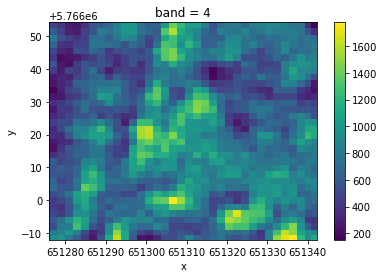

In [44]:
cmos.fit_transform(TOA).isel(band=4).plot()

In [45]:
cmos.step_outputs['column offset noise'].isel(band=0).std()

<xarray.DataArray ()>
array(0.00022436)
Coordinates:
    band     int64 0

In [46]:
from pyeosim.postprocess import CmosReflectance

In [47]:
cmos_pipe = CmosReflectance(cmos, TOA_ref)
cmos_pipe.fit(TOA)

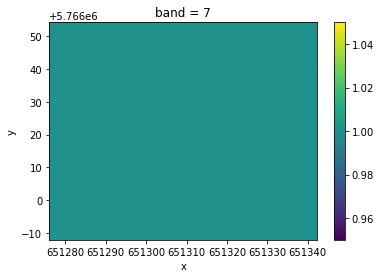

In [48]:
cmos_pipe.ff_frame.isel(band=7).plot()

In [49]:
ref = cmos_pipe.transform(TOA)

In [50]:
from pyeosim._sensor import add_ktc_noise

In [51]:
un = cmos_pipe.cmos_sensor.transform(xarray.concat([TOA]*10, dim='repeat'))
un2 = cmos_pipe.cmos_sensor.transform(TOA_ref)
ref_2 = un/un2

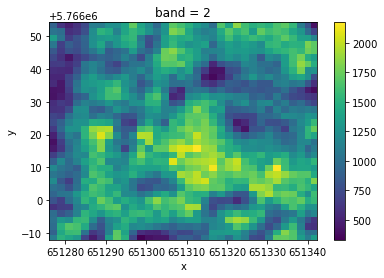

In [52]:
un.isel(repeat=6, band=2).plot()

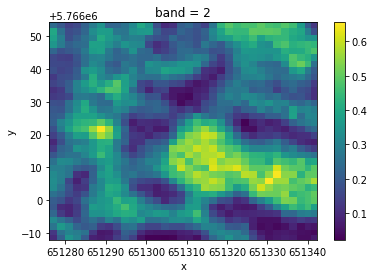

In [53]:
ref.isel(band=2).plot()

In [54]:
bgr = ref.isel(band=[2,1,0])

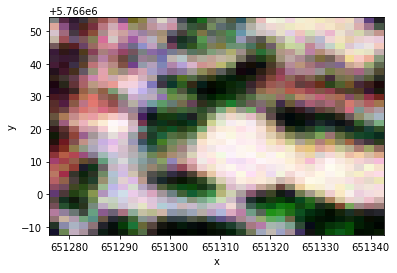

In [55]:
rgb(bgr)

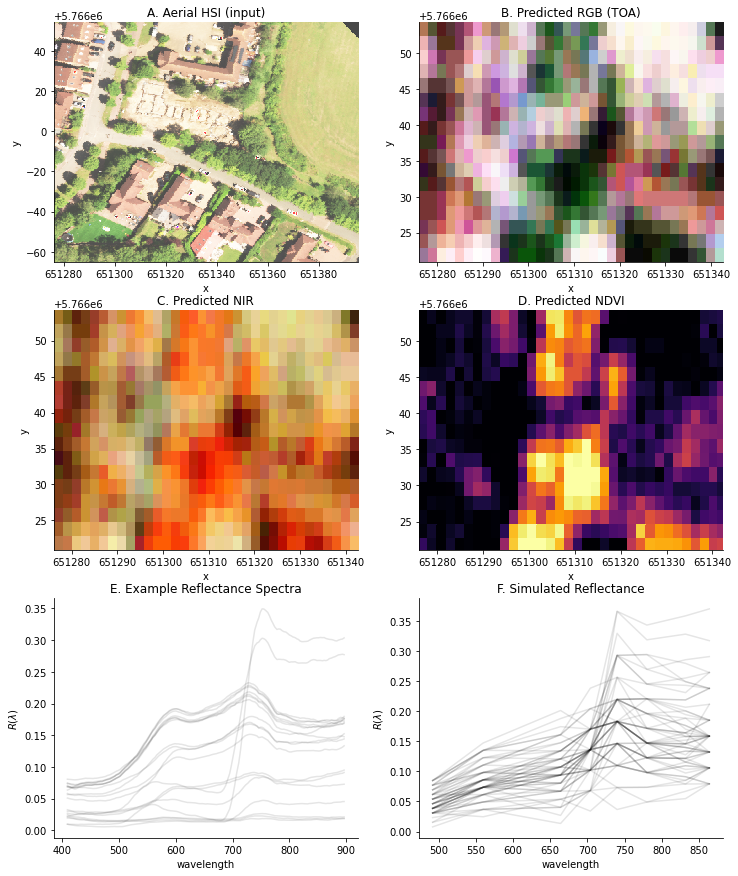

In [238]:
sig = cmos.transform(TOA)
out_r = sig/cmos.fit_transform(TOA_ref).mean(['x','y'])
sensor_wlen = list(cmos.spectral_response.band_wavelengths.values())
out_rp = out_r.assign_coords(
    wavelength = ('band', sensor_wlen)
).swap_dims({'band': 'wavelength'})

rgb_orig = im.isel(wavelength=[70,40,20]).swap_dims({'wavelength':'band'})
bgr = sig.isel(band=[2,1,0])
nir = out_r.isel(band=[6,1,0])
ndvi = ((out_r.isel(band=6) - out_r.isel(band=2))/(out_r.isel(band=6) + out_r.isel(band=2)))

fig, ax = plt.subplots(3,2, figsize=(12,15))

rgb(rgb_orig,ax=ax[0][0])
ax[0][0].set_title('A. Aerial HSI (input)')

rgb(bgr,ax=ax[0][1])
ax[0][1].set_title('B. Predicted RGB (TOA)')

rgb(nir,ax=ax[1][0])
ax[1][0].set_title('C. Predicted NIR')

ndvi.plot(ax=ax[1][1], add_colorbar=False, vmin=0, cmap='inferno', robust = True)
ax[1][1].set_title('D. Predicted NDVI')

im_ref_s=im_ref.stack(pix=['x','y'])
im_ref_s = im_ref_s.assign_coords(pix=np.arange(len(im_ref_s.pix)))
im_ref_s[:,::1000].plot(hue='pix', c='k', alpha=.1, add_legend=False, ax=ax[2][0])
ax[2][0].set_title('E. Example Reflectance Spectra')
ax[2][0].set_ylabel(r'$R(\lambda)$')

out_rpf = out_rp.stack(pix=['x','y'])
out_rpf = out_rpf.assign_coords(pix=np.arange(len(out_rpf.pix)))
out_rpf[:,::10].plot(hue='pix', c='k', alpha=.1, add_legend=False, ax=ax[2][1])
ax[2][1].set_title('F. Simulated Reflectance')
ax[2][1].set_ylabel(r'$R(\lambda)$')
sns.despine()
plt.savefig('outputs/test_output_cmos.png')

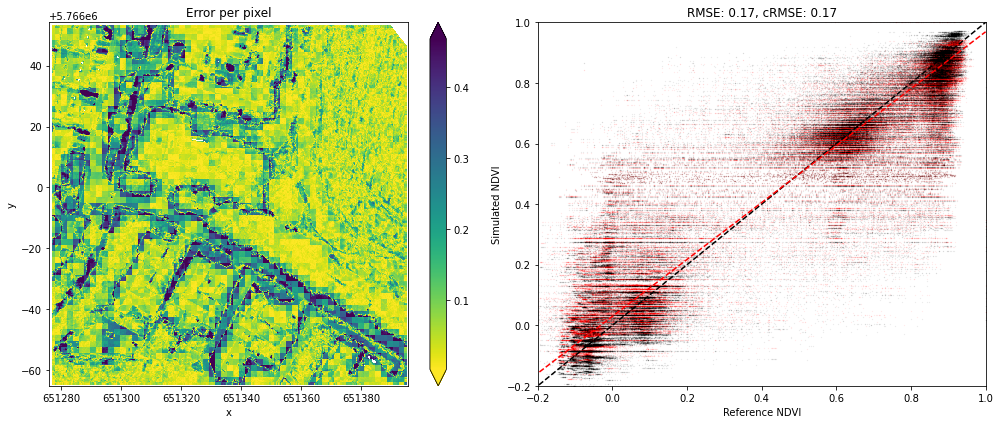

In [16]:
out_interp = out_r.interp(x=im_ref.x, y=im_ref.y, method='nearest')
out_interp = out_interp.assign_coords(band_name=('band', ['B2','B3','B4','B5','B6','B7','B8','B8A']))
ndvi_ref = NDVI(im_ref, min_val=-.2)
ndvi_sim = NDVI(out_interp)
exp1 = calibrate_and_score(out_interp, im_ref)

f, ax = plt.subplots(ncols=2, figsize=(14,6))
(np.sqrt((ndvi_ref - ndvi_sim)**2)).plot(robust=True, ax=ax[0],cmap='viridis_r')
ax[0].set_title('Error per pixel')
plot_linear_calibration(exp1,ax[1])
ax[1].set_xlabel('Reference NDVI')
ax[1].set_ylabel('Simulated NDVI')
ax[1].set_xlim(-.2,1)
ax[1].set_ylim(-.2,1)
plt.tight_layout()

Text(0.5, 1.0, 'Sensor Dark Noise')

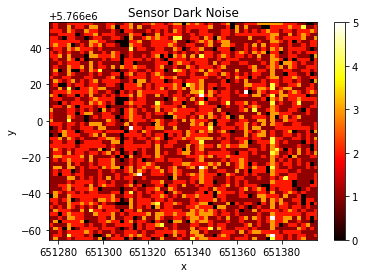

In [7]:
cmos.transform(xarray.zeros_like(TOA)).isel(band=0).plot(cmap='hot')
plt.title('Sensor Dark Noise')

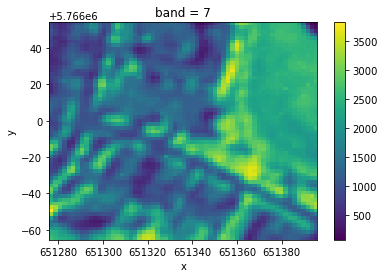

In [8]:
cmos2 = TdiCMOS(integration_time=.1,
               sense_node_gain=35,
               dark_current=1000,
               ccd_vref=1,
               adc_gain=4000,
               adc_vref=1,dark_factor=.01
              )
sig=cmos2.fit_transform(TOA)
sig.isel(band=7).plot()

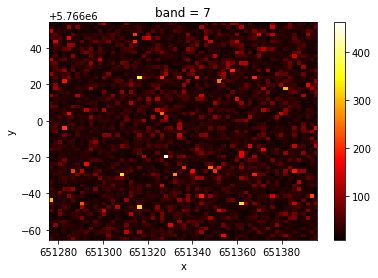

In [9]:
# Generate a sensor dark signal
cmos2.transform(xarray.zeros_like(TOA)).isel(band=7).plot(cmap='hot')